In [1]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra
using LimberJack
using Interpolations

discourse.julialang.org/t/is-there-a-turing-alternative-to-pm-deterministic-from-pymc3/38667

https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Latent.html

In [2]:
# Squared-exponential covariance function
sqexp_cov_fn(D, mu, phi) = @.(mu * exp(-D^2 / (2*phi))) + 0.005 * LinearAlgebra.I
# Exponential covariance function
exp_cov_fn(D, mu, phi) = @.(mu * exp(-D / phi)) + 0.005 * LinearAlgebra.I

exp_cov_fn (generic function with 1 method)

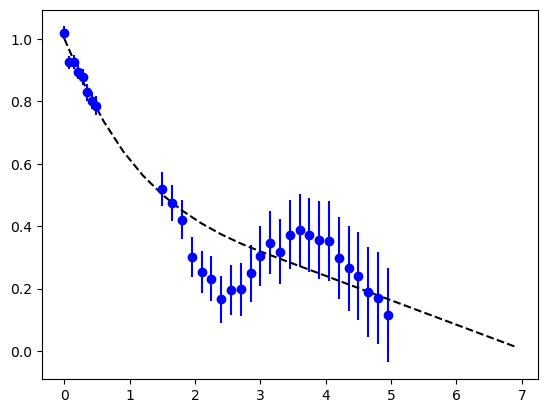

8
24


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffc6292e250>

In [3]:
cosmology = Cosmology()
data_1_x = Vector(0:0.07:0.5) 
println(length(data_1_x))
data_2_x = Vector(1.5:0.15:5)
println(length(data_2_x))
data_x = zeros(length(data_1_x)+length(data_2_x), 1)
data_x[1:length(data_1_x), 1] = data_1_x
data_x[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = data_2_x
N = length(data_x)

data = similar(vec(data_x))
data[1:length(data_1_x), 1] = cosmology.Dz(vec(data_1_x)) .* (1 .+ randn(length(data_1_x)) .* 0.03)
data[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = cosmology.Dz(vec(data_2_x)) .* (1 .+ 0.5 .* (sin.(vec(data_2_x)./0.5) + randn(length(data_2_x)) * 0.1))
#data = cosmology.Dz(vec(data_x)) .* (1 .+ 0.5 .* (sin.(vec(data_x)./0.5) + randn(N) * 0.1))
data_err = vec(@.((0.02 * data) + (0.03 * vec(data_x))))
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo")
gp_x = Vector(0:0.3:7)
gp_N = length(gp_x)
plt.plot(gp_x, cosmology.Dz(gp_x) .* ones(gp_N), "k--")

In [4]:
data_cov = zeros(N, N)
for i in 1:N
    data_cov[i,i] = data_err[i]^2 
end

In [5]:
function model_latent_GP(mu, phi, v; 
                         X=data_x, data_cov=data_cov, cov_fn=sqexp_cov_fn, cosmology=Cosmology())
    # Dimensions of predictors .
    N, P = size(X)
    gp_x = Vector(0:0.3:7)
    gp_N = length(gp_x)
    Q = N + gp_N
    Z = [X; gp_x]
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), Z, dims=1)
    Dz = cosmology.Dz(vec(X))
    Dz_gp = cosmology.Dz(vec(gp_x))
    
    # Set up GP
    K = cov_fn(D, mu, phi)
    Koo = K[(N+1):end, (N+1):end] # GP-GP cov
    Knn = K[1:N, 1:N]             # Data-Data cov
    Kno = K[1:N, (N+1):end]       # Data-GP cov
    
    #rand(MvNormal(zeros(gp_N), 0.1*ones(gp_N)))
    gp = Dz_gp .+ cholesky(Koo).U' * v
    # Conditional 
    Koo_inv = inv(Koo)            
    C = Kno * Koo_inv
    m = C * gp
    return gp, m
end

model_latent_GP (generic function with 1 method)

In [6]:
N_samples = 100
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 32)
for i in 1:N_samples
    mu = rand(Exponential(1))
    phi = rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(gp_N), 0.1 .* ones(gp_N)))
    gps[i, :], ys[i, :], = model_latent_GP(mu, phi, v)
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

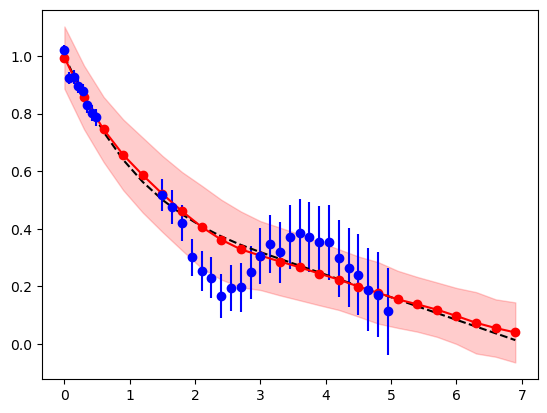

PyObject <matplotlib.collections.PolyCollection object at 0x7ffc526a3910>

In [7]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, cosmology.Dz(gp_x), "k--", label="LCDM")
plt.plot(vec(gp_x), vec(gp_m), "ro-")
plt.fill_between(vec(gp_x), vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red")

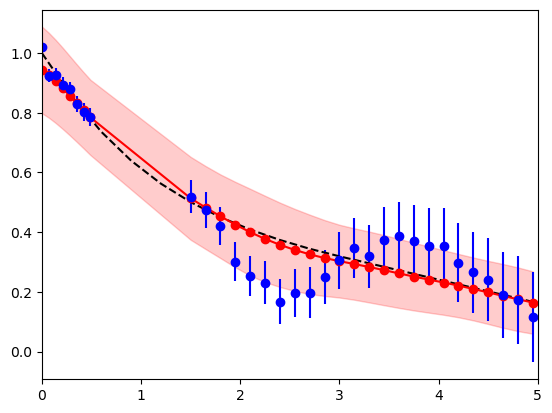

(0.0, 5.0)

In [8]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, cosmology.Dz(gp_x), "k--", label="LCDM")
plt.plot(vec(data_x), vec(y_m), "ro-")
plt.fill_between(vec(data_x), vec(y_m .+ y_s),  vec(y_m .- y_s), alpha=0.2, color="red")
plt.xlim(0., 5.)

In [14]:
@model function latent_GP(y; X=data_x, data_cov=data_cov, cov_fn=sqexp_cov_fn, cosmology=Cosmology())
    # Dimensions of predictors .
    N, P = size(X)
    gp_x = Vector(0:0.3:7)
    gp_N = length(gp_x)
    Q = N + gp_N
    Z = [X; gp_x]
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), Z, dims=1)
    Dz = cosmology.Dz(vec(X))
    Dz_gp = cosmology.Dz(vec(gp_x))
    
    # Priors.
    mu ~ Exponential(1)
    phi ~ Uniform(0.1, 3)
    
    # Set up GP
    K = cov_fn(D, abs(mu), phi)
    Koo = K[(N+1):end, (N+1):end] # GP-GP cov
    Knn = K[1:N, 1:N] + data_cov  # Data-Data cov
    Kno = K[1:N, (N+1):end]       # Data-GP cov
    
    v ~ MvNormal(zeros(gp_N), 0.3 .* ones(gp_N))
    gp = Dz_gp .+ cholesky(Koo).U' * v
    # Conditional 
    Koo_inv = inv(Koo)            
    C = Kno * Koo_inv
    m = C * gp
    y ~ MvNormal(m, data_cov)
end

latent_GP (generic function with 1 method)

In [15]:
chain = sample(latent_GP(data), HMC(0.005, 100), 1000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:05:04


Chains MCMC chain (1000×35×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = mu, phi, v[1], v[2], v[3], v[4], v[5], v[6], v[7], v[8], v[9], v[10], v[11], v[12], v[13], v[14], v[15], v[16], v[17], v[18], v[19], v[20], v[21], v[22], v[23], v[24]
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

          mu    0.4788    0.4323     0.0137    0.0492    107.6491    1.0010
         phi    0.7314    0.3525     0.0111    0.0364     90.1826    0.9997
        v[1]    0.0537    0.2321     0.0073    0.0171    154.5707    1.0076
        v[2]   -0.1401    0.1888     0.0060    0.0082    524.7271    1.0000
        v[3]    0.1024    0.2769     0.0088    0.0085    827.86

┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364


In [19]:
mu_p = group(chain, :mu).value.data[:, :, 1]
phi_p = group(chain, :phi).value.data[:, :, 1]
v_p = group(chain, :v).value.data[:, :, 1]

N_samples = length(mu_p)
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 32)
for i in 1:N_samples
    gps[i, :], ys[i, :],  = model_latent_GP(mu_p[i], phi_p[i], v_p[i, :])
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

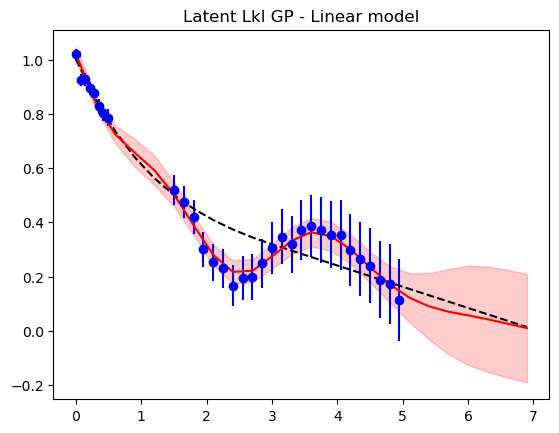

PyObject Text(0.5, 1.0, 'Latent Lkl GP - Linear model')

In [22]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, cosmology.Dz(gp_x), "k--", label="LCDM")
plt.plot(vec(gp_x), vec(gp_m), "r-")
plt.fill_between(vec(gp_x), vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red")
plt.title("Latent Lkl GP - Linear model")

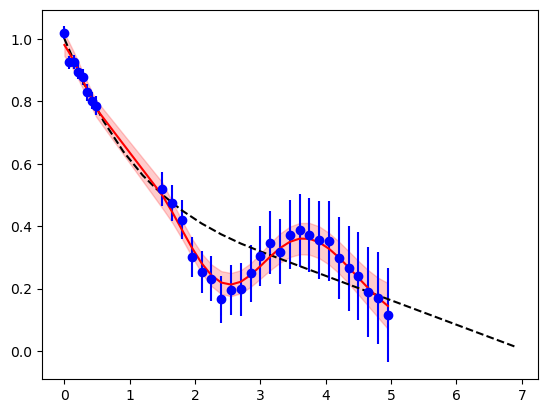

PyObject <matplotlib.collections.PolyCollection object at 0x7ffc631044f0>

In [21]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, cosmology.Dz(gp_x), "k--", label="LCDM")
plt.plot(vec(data_x), vec(y_m), "r-")
plt.fill_between(vec(data_x), vec(y_m .+ y_s),  vec(y_m .- y_s), alpha=0.2, color="red")